In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
train = pd.read_csv('DATASET/train.csv')
test = pd.read_csv('DATASET/test.csv')

In [3]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 12137810 rows and 10 columns
The test data has 3706907 rows and 9 columns


In [4]:
train.head()

,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
0,IDsrk7SoW,2017-01-14 09:42:09,4709696.0,887235,17714,20301556,e,Firefox,NaN,0
1,IDmMSxHur,2017-01-18 17:50:53,5189467.0,178235,21407,9434818,b,Mozilla Firefox,Desktop,0
2,IDVLNN0Ut,2017-01-11 12:46:49,98480.0,518539,25085,2050923,a,Edge,NaN,0
3,ID32T6wwQ,2017-01-17 10:18:43,8896401.0,390352,40339,72089744,c,Firefox,Mobile,0
4,IDqUShzMg,2017-01-14 16:02:33,5635120.0,472937,12052,39507200,d,Mozilla Firefox,Desktop,0


In [5]:
# imputing missing values
train['siteid'].fillna(-999, inplace=True)
test['siteid'].fillna(-999, inplace=True)

train['browserid'].fillna("None",inplace=True)
test['browserid'].fillna("None", inplace=True)

train['devid'].fillna("None",inplace=True)
test['devid'].fillna("None",inplace=True)

In [6]:

# create timebased features

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

#train['tweekday'] = train['datetime'].dt.weekday
#test['tweekday'] = test['datetime'].dt.weekday

train['tyear'] = train['datetime'].dt.year
test['tyear'] = test['datetime'].dt.year

train['month'] = train['datetime'].dt.month
test['month'] = test['datetime'].dt.month

#train['tday'] = train['datetime'].dt.day
#test['tday'] = test['datetime'].dt.day

train['thour'] = train['datetime'].dt.hour
test['thour'] = test['datetime'].dt.hour

train['tminute'] = train['datetime'].dt.minute
test['tminute'] = test['datetime'].dt.minute

In [7]:
# create aggregate features
site_offer_count = train.groupby(['siteid','offerid']).size().reset_index()
site_offer_count.columns = ['siteid','offerid','site_offer_count']

site_offer_count_test = test.groupby(['siteid','offerid']).size().reset_index()
site_offer_count_test.columns = ['siteid','offerid','site_offer_count']

site_cat_count = train.groupby(['siteid','category']).size().reset_index()
site_cat_count.columns = ['siteid','category','site_cat_count']

site_cat_count_test = test.groupby(['siteid','category']).size().reset_index()
site_cat_count_test.columns = ['siteid','category','site_cat_count']

site_mcht_count = train.groupby(['siteid','merchant']).size().reset_index()
site_mcht_count.columns = ['siteid','merchant','site_mcht_count']

site_mcht_count_test = test.groupby(['siteid','merchant']).size().reset_index()
site_mcht_count_test.columns = ['siteid','merchant','site_mcht_count']

In [8]:

# joining all files
agg_df = [site_offer_count,site_cat_count,site_mcht_count]
agg_df_test = [site_offer_count_test,site_cat_count_test,site_mcht_count_test]

for x in agg_df:
    train = train.merge(x)
    
for x in agg_df_test:
    test = test.merge(x)

In [9]:

# Label Encoding
from sklearn.preprocessing import LabelEncoder
for c in list(train.select_dtypes(include=['object']).columns):
    if c != 'ID':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

In [10]:

# sample 10% data - to avoid memory troubles
# if you have access to large machines, you can use more data for training

#train = train.sample()
print (train.shape)

(12137810, 17)


In [11]:
# select columns to choose
cols_to_use = [x for x in train.columns if x not in list(['ID','datetime','click'])]

In [12]:

# standarise data before training
scaler = StandardScaler().fit(train[cols_to_use])

strain = scaler.transform(train[cols_to_use])
stest = scaler.transform(test[cols_to_use])

In [13]:
# train validation split
X_train, X_valid, Y_train, Y_valid = train_test_split(strain, train.click, test_size = 0.1, random_state=2017)

In [14]:
print (X_train.shape)
print (X_valid.shape)
print (Y_train.shape)
print (Y_valid.shape)

(10924029, 14)
(1213781, 14)
(10924029,)
(1213781,)


In [15]:
# model architechture
def keras_model(train):
    
    input_dim = train.shape[1]
    classes = 2
    
    model = Sequential()
    model.add(Dense(100, activation = 'relu', input_shape = (input_dim,)))
    model.add(Dense(30, activation = 'relu'))
    model.add(Dense(classes, activation = 'softmax'))
    model.compile(optimizer = 'adam', loss='binary_crossentropy',metrics = ['accuracy'])
    return model

callback = EarlyStopping(monitor='val_acc',patience=3)

In [16]:
# one hot target columns
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)

In [17]:
# train model
model = keras_model(X_train)
model.fit(X_train, Y_train, 2000, 100, callbacks=[callback],validation_data=(X_valid, Y_valid),shuffle=True)

Train on 10924029 samples, validate on 1213781 samples
Epoch 1/100
10924029/10924029 [==============================] - 19s - loss: 0.0802 - acc: 0.9730 - val_loss: 0.0653 - val_acc: 0.9778
Epoch 2/100
10924029/10924029 [==============================] - 19s - loss: 0.0635 - acc: 0.9783 - val_loss: 0.0632 - val_acc: 0.9782
Epoch 3/100
10924029/10924029 [==============================] - 18s - loss: 0.0606 - acc: 0.9792 - val_loss: 0.0600 - val_acc: 0.9793
Epoch 4/100
10924029/10924029 [==============================] - 18s - loss: 0.0582 - acc: 0.9799 - val_loss: 0.0574 - val_acc: 0.9801
Epoch 5/100
10924029/10924029 [==============================] - 19s - loss: 0.0567 - acc: 0.9804 - val_loss: 0.0597 - val_acc: 0.9790
Epoch 6/100
10924029/10924029 [==============================] - 18s - loss: 0.0557 - acc: 0.9807 - val_loss: 0.0561 - val_acc: 0.9807
Epoch 7/100
10924029/10924029 [==============================] - 18s - loss: 0.0550 - acc: 0.9809 - val_loss: 0.0574 - val_acc: 0.9801


In [18]:
# check validation accuracy
vpreds = model.predict_proba(X_valid)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true = Y_valid[:,1], y_score=vpreds)

1211680/1213781 [============================>.] - ETA: 0s

0.97716602988356582

In [19]:
# predict on test data
test_preds = model.predict_proba(stest)[:,1]

3706880/3706907 [============================>.] - ETA: 0s

In [20]:
# create submission file
submit = pd.DataFrame({'ID':test.ID, 'click':test_preds})
submit.to_csv('Submission/Keras_subNew5.csv', index=False)

In [21]:
from xgboost import XGBClassifier

/home/anirudh/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
test.head()

,ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,tyear,month,thour,tminute,site_offer_count,site_cat_count,site_mcht_count
0,IDFDJVI,2017-01-22 09:55:48,755610.0,808980,17714,26391770,1,8,0,2017,1,9,55,1,16,14
1,IDfbJpA,2017-01-22 09:55:48,755610.0,794970,17714,26391770,5,8,0,2017,1,9,55,1,16,14
2,IDF9SUX,2017-01-22 09:55:48,755610.0,862911,17714,26391770,0,1,3,2017,1,9,55,1,16,14
3,IDwx0Vu,2017-01-22 09:55:48,755610.0,852044,17714,26391770,0,7,0,2017,1,9,55,1,16,14
4,IDwY76g,2017-01-22 09:55:48,755610.0,259313,17714,26391770,4,3,1,2017,1,9,55,1,16,14


In [23]:
#import gc
#del X_valid
#del Y_valid
#del X_train
#del Y_train
#del test
#del model
#del submit
#del 
#gc.collect()

264

In [23]:
XGB_model = XGBClassifier()

In [24]:
XGB_model.fit(strain, train.click)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [25]:
test_preds2 = XGB_model.predict_proba(stest)[:,1]

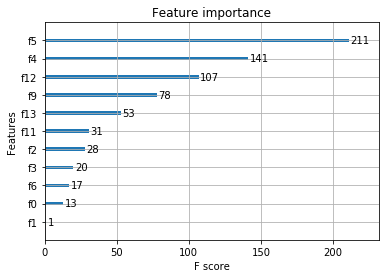

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(XGB_model)
plt.show()

In [27]:
test_preds2[1]

0.0030760586

In [28]:
test_preds2[2]

0.00052707712

In [29]:
test = pd.read_csv('DATASET/test.csv')

In [30]:
submitXGB = pd.DataFrame({'ID':test.ID, 'click':test_preds2})
submitXGB.to_csv('Submission/XGB2new1.csv', index=False)

In [31]:
test_pred_ensemble = (test_preds2 + test_preds)/2.0
submitE = pd.DataFrame({'ID':test.ID, 'click':test_pred_ensemble})
submitE.to_csv('Submission/ENSEMBLE2new1.csv', index=False)

In [33]:
#X_train.shape

In [34]:
vpreds.shape

(1213781,)

In [35]:
Y_train_pred = model.predict(strain)[:,1]

In [36]:
roc_auc_score(train.click,Y_train_pred)

0.97617703213793139

In [37]:
strain.shape

(12137810, 16)

In [38]:
Y_train_pred.shape

(12137810,)

In [39]:
Data_l1 = pd.DataFrame(data=strain)

In [40]:
Data_l1["Y_pred"]=Y_train_pred

In [41]:
Data_l1.shape

(12137810, 17)

In [42]:
Test_l1 = pd.DataFrame(data=stest)

In [ ]:
Test_l1["Y_pred"] = test_preds

In [ ]:
XGB_model_L2 = XGBClassifier()
XGB_model_L2.fit(Data_l1, train.click)

In [ ]:
test_preds_L2 = XGB_model_L2.predict_proba(Test_l1)[:,1]

In [ ]:
submitXGB_l2 = pd.DataFrame({'ID':test.ID, 'click':test_preds_L2})
#submitXGB_l2.to_csv('Submission/XGB_L2_2.csv', index=False)

In [ ]:
test_preds_L2[1]

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(XGB_model_L2)
plt.show()